# Titanic
This notebook is my second attempt at building a classification model for the Titanic dataset ([here](https://github.com/iherman10/titanic/blob/main/titanic.ipynb) is my original). I'm building a new one after completing Chapter 3 of Hands-On Machine Learning, which went through the steps to build and evaluate classification models (using the MNIST dataset). 

I might reference code from Chapter 3 of Hands-On Machine Learning ([notebook](https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb)). 

# Frame the problem
This is a classification task, as we need to predict whether a passenger survived or not. 

## Measuring performance
There are several metrics we can use to measure the performance of a classification model. That being said, Kaggle ranks submissions for this dataset based on accuracy (% of correct predictions). Both _precision_ and _recall_ should be high in order to have a highly accurate model. We can stick with __accuracy__ for now. 

# Get the data
We have a couple files avilable: `train.csv` and `test.csv`. 

In [1]:
import pandas as pd 
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
train.shape, test.shape

((891, 12), (418, 11))

# Explore the data

In [4]:
# Create copy to explore the data
explore = train.copy()

In [5]:
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Quick observations: 
- `PassengerID` is not useful 
- `Survived` is the target variable, should be stored separately in target/label array.  
- `Pclass` is really more of a categorical variable, can perform OneHot encoding on it, 
- `Age` has significant number of missing values which should be imputed. Also should be normalized/standardized. 
- `Ticket` is probably not so useful, unclear what the data really means there. 
- `Fare` should be normalized/standardized. 
- `Cabin` has too many missing values. This can be dropped. 
- `Embarked` can be OneHot encoded. 

In [6]:
explore.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [7]:
explore.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


__38% of passengers in this dataset survived__. So the positive class for our target variable is less common but not exceedingly rare. Meaning there isn't any explicit need to focus so heavily on precision/recall trade-off. 

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'family'}>,
        <Axes: title={'center': 'log_age'}>,
        <Axes: title={'center': 'log_fare'}>]], dtype=object)

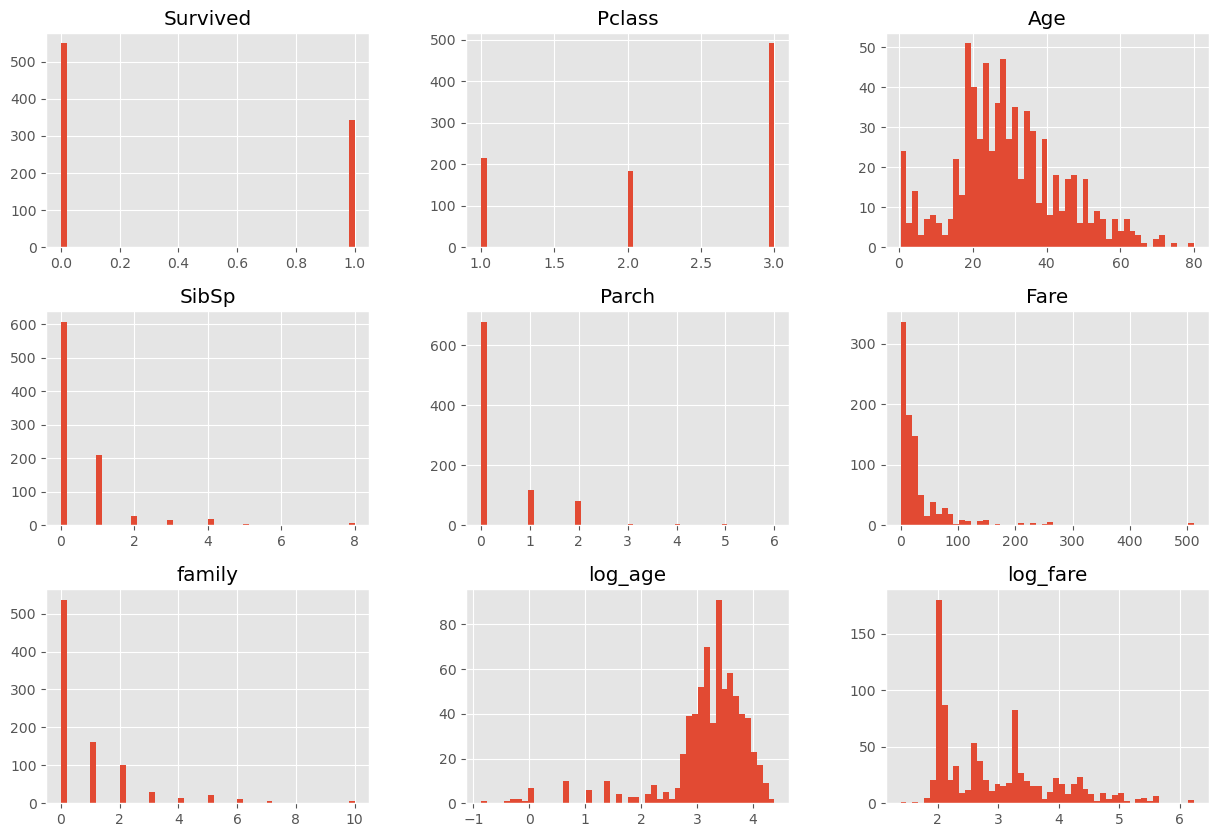

In [63]:
# Look at distributions
import matplotlib.pyplot as plt 
plt.style.use('ggplot')  

explore.hist(bins=50, figsize=(15, 10))

Potential numerical data transformations to explore: 

- Add total number of family members: `family = Parch + SibSP` 
- Log-transform `Age` and `Fare`


array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'family'}>,
        <Axes: title={'center': 'log_age'}>,
        <Axes: title={'center': 'log_fare'}>]], dtype=object)

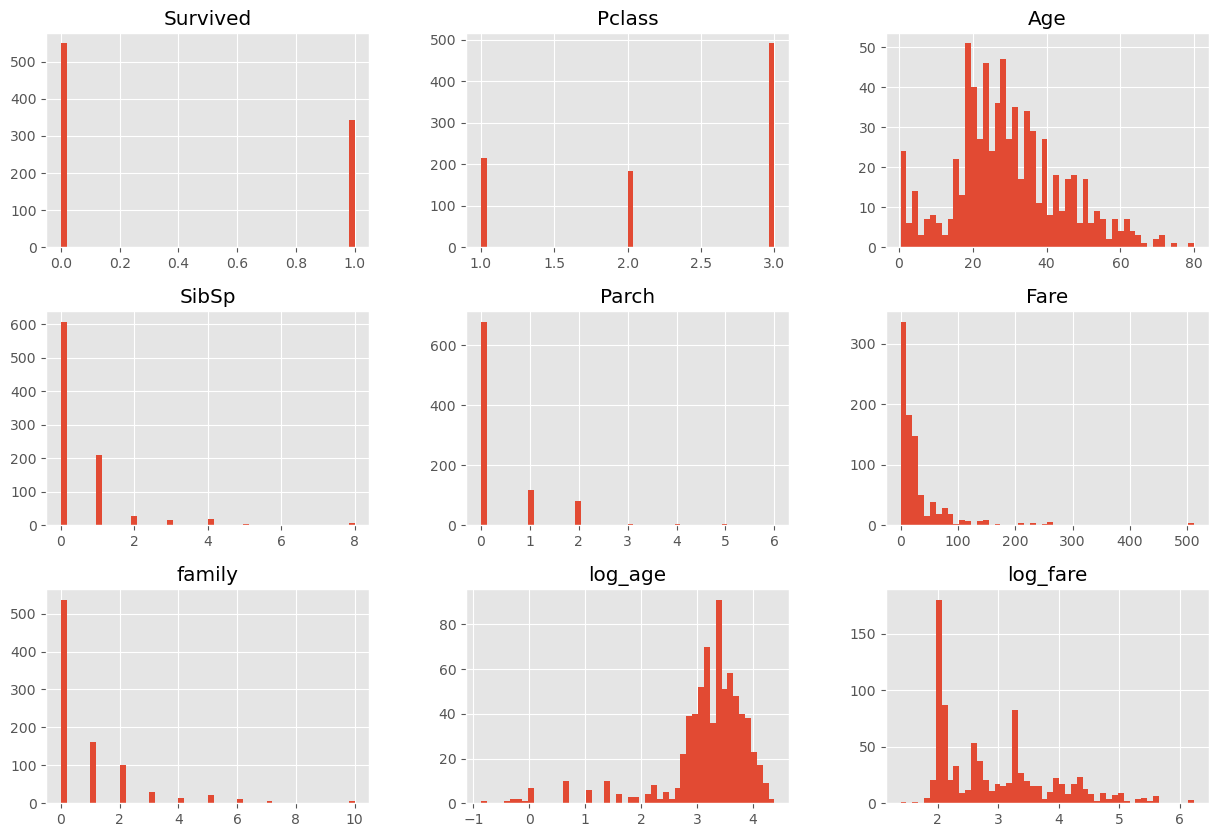

In [64]:
# Quick transformations 
import numpy as np
explore['family'] = explore['Parch'] + explore['SibSp']
explore['log_age'] = np.log(explore['Age'])
explore['log_fare'] = np.log(explore['Fare'].replace(0, np.nan))
explore.hist(bins=50, figsize=(15, 10))

In [65]:
# Look for correlations in the data
corr_matrix = explore.corr(numeric_only=True)
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
log_fare    0.325452
Fare        0.257307
Parch       0.081629
family      0.016639
SibSp      -0.035322
Age        -0.077221
log_age    -0.127863
Pclass     -0.338481
Name: Survived, dtype: float64

At first glance, `log_fare` is positively correlated with `Survived`, and `Pclass` is negatively correlated with `Survived`. Another variable of note is `log_age`, which is negatively correlated with `Survived`. 

On the surface, these relationships make directional sense. 
- If someone's fare is higher, they're likely wealthier and staying in a nicer cabin. Did these cabins also have more direct access to lifeboats? 
- `Pclass` has a similar possible explanation. The higher the number for `Pclass`, the lower the class is technically speaking. Maybe lower class cabins were closer to the bottom of the boat, further away from life boats. 
- It makes sense to think that younger passengers are more likely to survive. They're faster, stronger, etc. 

In [66]:
explore.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'family', 'log_age', 'log_fare'],
      dtype='object')

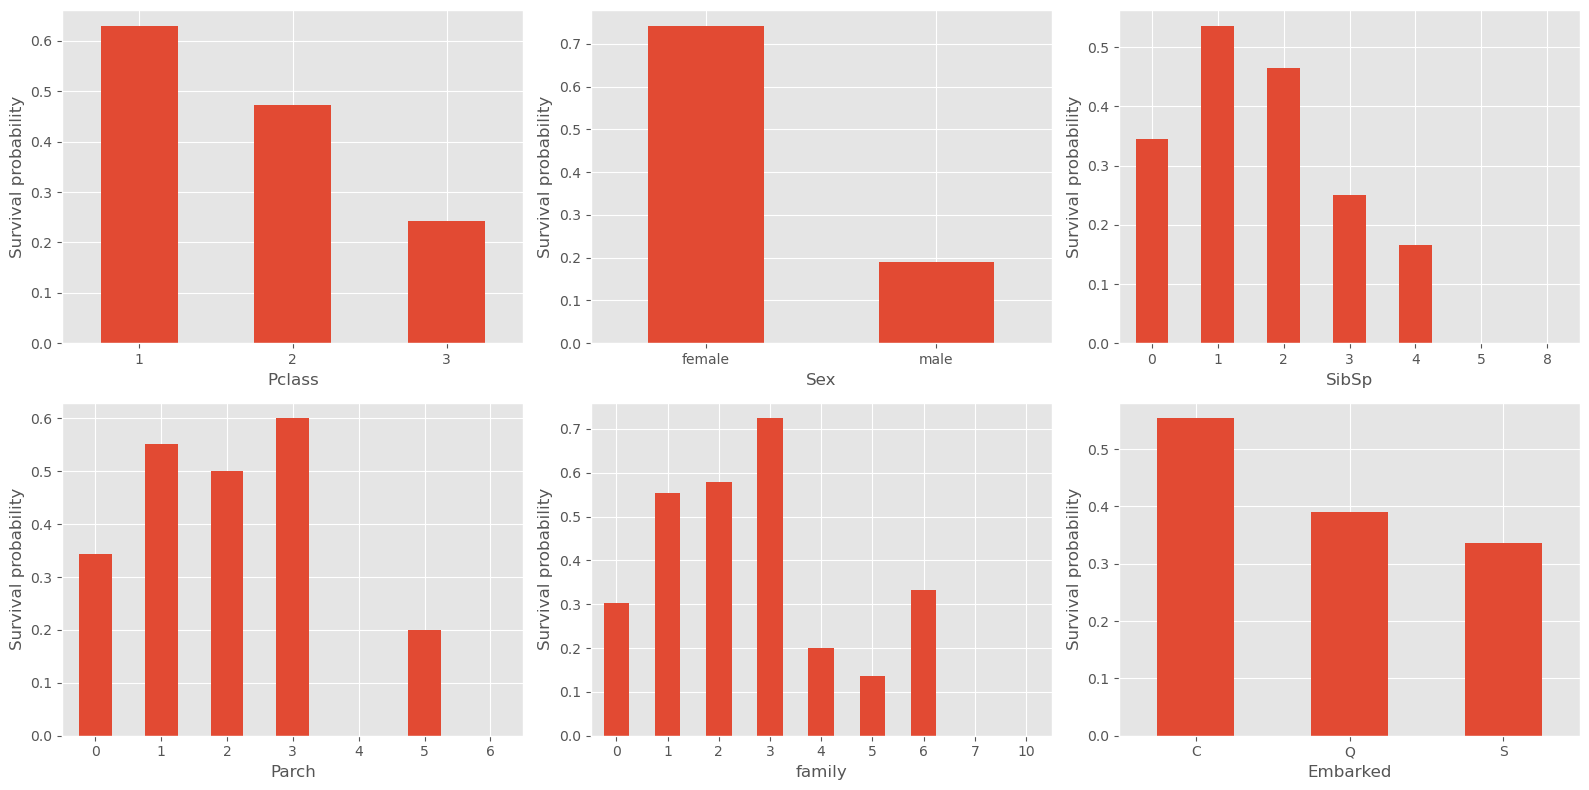

In [135]:
def plot_survival_probability(attribute, ax):
    grouped_df = explore.groupby(attribute)['Survived'].mean()
    grouped_df.plot(kind='bar', ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')  
    plt.ylabel('Survival probability')

fig, axs = plt.subplots(2, 3, figsize=(16, 8))  
plt.subplot(231); plot_survival_probability('Pclass', axs[0, 0])
plt.subplot(232); plot_survival_probability('Sex', axs[0, 1])
plt.subplot(233); plot_survival_probability('SibSp', axs[0, 2])
plt.subplot(234); plot_survival_probability('Parch', axs[1, 0])
plt.subplot(235); plot_survival_probability('family', axs[1, 1])
plt.subplot(236); plot_survival_probability('Embarked', axs[1, 2])

plt.tight_layout()  
plt.show()  

From the above plots, we might be able to say the following passengers are more likely to survive: 
- Those in 1st class 
- Women 
- Had 3 family members on board (including parents, children, siblings, and spouses)
- Embarked from point 'C'

However, we haven't explored yet if there's significant correlation between these groups (e.g. more women in first class, or all first class passengers embarked at point 'C'). We can look at: 
1. Overlap of `Pclass` and `Sex`
2. Overlap of `Pclass` and `family` 
3. Overlap of `Pclass` and `Embarked` 

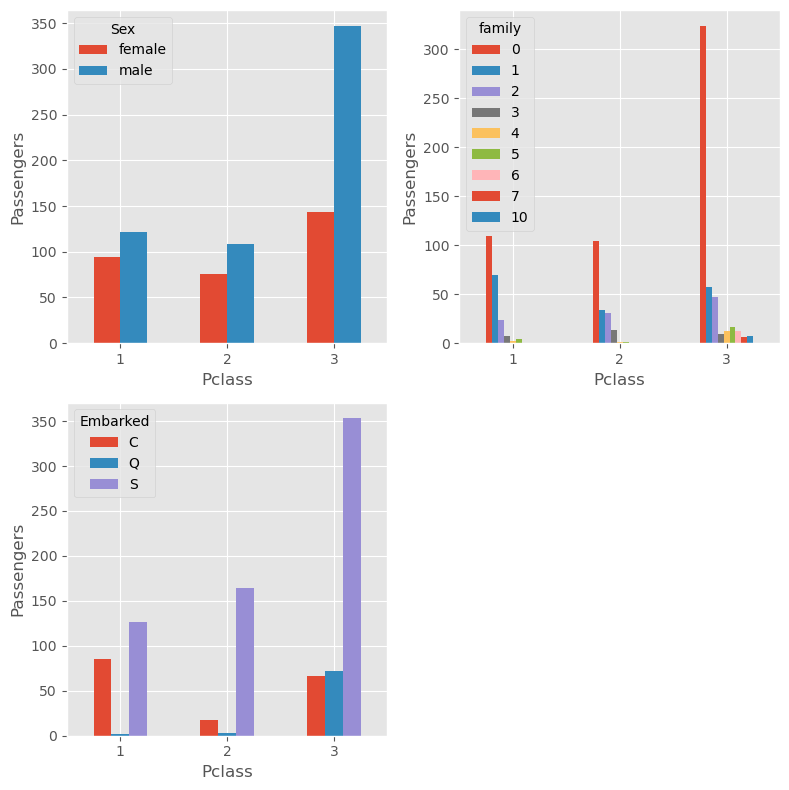

In [136]:
def plot_group_overlap(group_1, group_2, ax):  
    grouped_df = explore.groupby(group_1)[group_2].value_counts().unstack()  
    grouped_df.plot(kind='bar', ax=ax)  
    ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')  
    ax.set_ylabel('Passengers')  
  
fig, axs = plt.subplots(2, 2, figsize=(8, 8))  
plot_group_overlap('Pclass', 'Sex', axs[0, 0])  
plot_group_overlap('Pclass', 'family', axs[0, 1])  
plot_group_overlap('Pclass', 'Embarked', axs[1, 0])  
  
# Remove the empty subplot  
fig.delaxes(axs[1, 1])  
  
plt.tight_layout()  
plt.show()  